# Simple Model
- BME 230A class project winter 2019
- Andrew E. Davidson
- [aedavids@ucsc.edu](mailto:aedavids@edu?subject=SimpleModel.ipynb)

Use logistic regression to classify tumor vs. normal from Gene Expression

## Overview
* preforms  basic data exploration
* train a tumor vs. normal classifier using logistic regression
* model is save to disk $rootDir/models/logisticRegressionTumorNormal.h5
* training set comprised of gene expression values from Xena data set. The data was randomly split into 80/20 train/test sets
* model summary
    ```
    total data set size 19,126 example each with 58,581 features

    training set accuracy = 0.9994
    test set accuracy = 0.9929

    confusion matrix
    [[1701   19]
     [   8 2098]]
    False positive rate: (predicting tumor while normal) 0.011
    False negative rate: (predicting normal while tumor) 0.004
    ```
    
see [simpleModelEvaluation.ipynb](simpleModelEvaluation.ipynb)

ref: [https://github.com/AEDWIP/BME-230a.git](https://github.com/AEDWIP/BME-230a.git)

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint, ProgbarLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Input, BatchNormalization, InputLayer, Activation
from keras.regularizers import L1L2
from keras.optimizers import Adam, SGD, Adadelta, Adagrad

import keras
print(
    "keras version should be Keras==2.1.6, new version can not save and restore models"
)
print("keras version:{}".format(keras.__version__))

import matplotlib.pyplot as plt

# fix random seed for reproducibility
theMeaningOfLife = 42
np.random.seed(theMeaningOfLife)

Using TensorFlow backend.


keras version should be Keras==2.1.6, new version can not save and restore models
keras version:2.1.6


# Load Data


In [2]:
!ls -l /bme-230a-ebs/data/tcga_target_gtex.h5

-rw-r--r-- 1 ubuntu ubuntu 8968513832 Mar 11 02:22 /bme-230a-ebs/data/tcga_target_gtex.h5


In [3]:
%%time

# mounted AWS EBS  BME-230a-project  volume id: vol-026c8e33988a1475b
rootDir = "/bme-230a-ebs"
dataFile = "{}/data/tcga_target_gtex.h5".format(rootDir)
store = pd.HDFStore(dataFile, mode="r")
print("store.info():{}".format(store.info()))
print("store.keys():{}".format(store.keys()))

store.info():<class 'pandas.io.pytables.HDFStore'>
File path: /bme-230a-ebs/data/tcga_target_gtex.h5
/expression            frame        (shape->[19126,58581])
/labels                frame        (shape->[1,7])        
store.keys():['/expression', '/labels']
CPU times: user 32 ms, sys: 12 ms, total: 44 ms
Wall time: 150 ms


In [4]:
%%time
# Load training set
X = pd.read_hdf(dataFile, "expression")
Y = pd.read_hdf(dataFile, "labels")

CPU times: user 172 ms, sys: 4.13 s, total: 4.3 s
Wall time: 1min 5s


In [5]:
X.head(3)

,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
GTEX-1117F-0226-SM-5GZZ7,-9.966041,-9.965816,-9.965881,4.4595,0.9343,-5.0116,7.5126,0.8164,-2.1140,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,5.326995,-9.9658
GTEX-1117F-0426-SM-5EGHI,-9.966041,-9.965816,-9.965881,1.1512,-1.2828,-6.5064,6.0777,-2.3147,0.5568,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,3.037565,-9.9658
GTEX-1117F-0526-SM-5EGHJ,-9.966041,-9.965816,-9.965881,5.2411,0.8488,-6.5064,10.0319,0.1257,-1.1172,-9.9658,...,-9.965816,-9.965849,-9.9658,-9.9658,-9.9658,-9.9658,-9.965849,-9.9658,4.302417,-9.9658


In [6]:
Y.head(3)

,category,disease,primary_site,sample_type,gender,study,tumor_normal
id,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,Adipose - Subcutaneous,Adipose Tissue,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0426-SM-5EGHI,Muscle - Skeletal,Muscle - Skeletal,Muscle,Normal Tissue,Female,GTEX,Normal
GTEX-1117F-0526-SM-5EGHJ,Artery - Tibial,Artery - Tibial,Blood Vessel,Normal Tissue,Female,GTEX,Normal


In [7]:
print("Y.shape:{}".format(Y.shape))

Y.shape:(19126, 7)


In [8]:
Y.describe()

,category,disease,primary_site,sample_type,gender,study,tumor_normal
count,19126,19126,19126,19126,19126,19126,19126
unique,93,93,46,16,3,3,2
top,Breast Invasive Carcinoma,Breast Invasive Carcinoma,Brain,Primary Tumor,Male,TCGA,Tumor
freq,1212,1212,1846,9185,10453,10534,10530


Text(0.5,1,'Category counts')

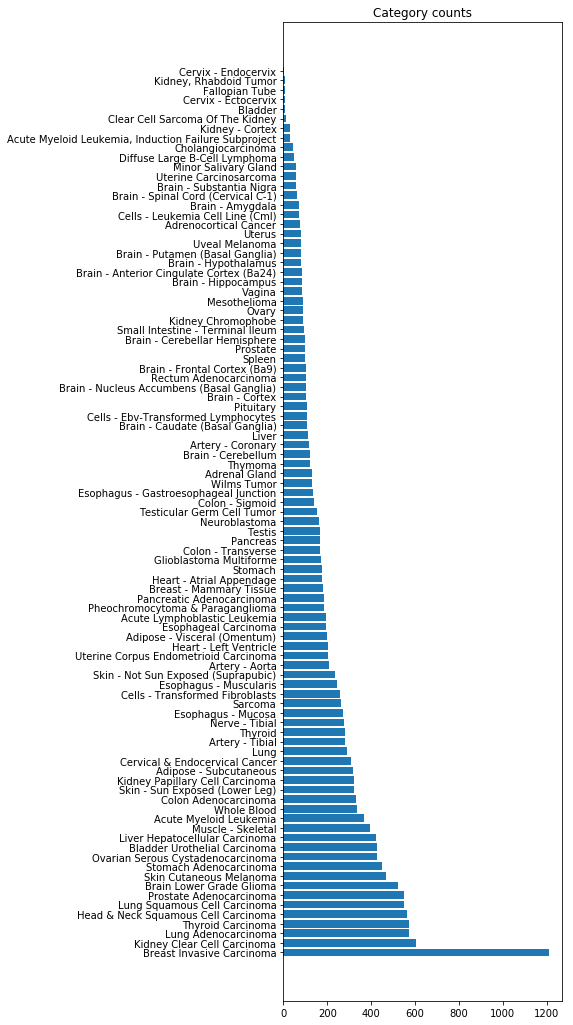

In [9]:
def plotCategoryCounts(df, colNameStr):
    '''
    TODO: make this more generic
    argument 
        df: a pandas data frame 
        colNameStr: 
        
    returns:
        (fix, axis)
    '''
    # countDF is series
    countDF = df[colNameStr].value_counts()
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 18)
    ax.barh(countDF.index, countDF)

    return (fig, ax)


fig, ax = plotCategoryCounts(Y, "category")
ax.set_title("Category counts")

In [10]:
# Convert tumor_normal  into numerical values
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(
    encoder.fit_transform(Y["tumor_normal"]), index=Y.index)
Y[["tumor_normal", "tumor_normal_value"]].head(3)

,tumor_normal,tumor_normal_value
id,,
GTEX-1117F-0226-SM-5GZZ7,Normal,0
GTEX-1117F-0426-SM-5EGHI,Normal,0
GTEX-1117F-0526-SM-5EGHJ,Normal,0


In [11]:
%%time
# Split into stratified training and test sets based on classes (i.e. tissue type) so that we have equal
# proportions of each tissue type in the train and test sets
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=theMeaningOfLife)

for train_index, test_index in split.split(X.values, Y["tumor_normal_value"]):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = Y["tumor_normal_value"][train_index], \
                        Y["tumor_normal_value"][test_index]

print(X_train.shape, X_test.shape)

(15300, 58581) (3826, 58581)
CPU times: user 968 ms, sys: 1.72 s, total: 2.69 s
Wall time: 2.71 s


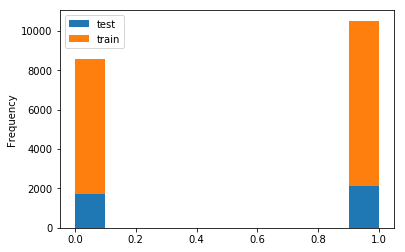

In [12]:
# checking if class balance is maintained
labels = {'train': (y_train), 'test': (y_test)}
label_df = pd.DataFrame(labels)
label_df.plot.hist(stacked=True)

In [13]:
print(y_train.head(3))
print(y_train.values[0:3])
print(y_train.shape)
y_train.describe()

id
GTEX-ZQG8-2426-SM-57WEE     0
GTEX-131YS-0005-SM-5NQAS    0
GTEX-13SLX-0526-SM-5S2ON    0
Name: tumor_normal_value, dtype: int64
[0 0 0]
(15300,)


count    15300.000000
mean         0.550588
std          0.497451
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: tumor_normal_value, dtype: float64

In [14]:
# this is a neural network with a single activation node
def logisticRegression(input_dim=None, output_dim=None, lr=0.001):
    '''
    implement a neural network with a single activation node. Uses a
    Adam optimizer with the binary_crossentropy function
    
    Includes a batch normalization preprocess step. normalizaton 
    typically reduces training time.
    
    arguments:
        input_dim:
           type int: the number of features in each sample
        
        outputDim: 
            type int the number of classes
        
        lr: 
            type float: scaling factor for adjusting weight. larger
            values may train faster how ever can cause optimization 
            algorithm to diverge if to large. Use loss curver plot
            to evaluate    
    
    return:
        keras.models
    '''
    classify = [
        InputLayer(input_shape=(input_dim, )),

        # TODO: Is Keras smart? only need to run preprocessing step
        # once
        BatchNormalization(),
        Dense(output_dim),  # dot(input, kernel) + bias
        Activation('sigmoid')
    ]

    model = Sequential(classify)

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy'])

    return model

In [18]:
%%time
modelName = "logisticRegressionTumorNormal"
logisticRegressionModel = logisticRegression(
    input_dim=X_train.shape[1], output_dim=1)

# https://keras.io/callbacks/
checkPointPath = "./models/{}.chkPt".format(modelName)
callbacks = [
    # monitor valuse either 'acc' for accuracy or 'loss'
    # 'val_loss' is loss on hold if valaidation_split is set
    # 'loss' is loss on training
    # same for 'acc' and 'val_acc'
    EarlyStopping(monitor='loss', patience=2, verbose=0),
    ModelCheckpoint(
        checkPointPath, monitor='loss', save_best_only=False, verbose=0)
    # FIXME: progbar generates run time error
    #,ProgbarLogger(count_mode='samples', stateful_metrics=None)
]

history = logisticRegressionModel.fit(
    X_train,
    y_train.values,
    shuffle=None,  # we already shuffled
    epochs=20,  #100
    batch_size=1024,
    # we already split the data
    validation_split=0.0,
    verbose=0,
    callbacks=callbacks)

logisticRegressionModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 58581)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 58581)             234324    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 58582     
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 292,906
Trainable params: 175,744
Non-trainable params: 117,162
_________________________________________________________________
CPU times: user 3min 36s, sys: 22.9 s, total: 3min 59s
Wall time: 1min 14s


In [19]:
%%time
# evaluate() computes the loss based on the input you pass
# predict() generates output predictions based on the input you pass it
evalTrain = logisticRegressionModel.evaluate(X_train, y_train, verbose=0)
evalTest = logisticRegressionModel.evaluate(X_test, y_test, verbose=0)
print("train")
print("Loss    : {:.4f}".format(evalTrain[0]))
print("Accuracy: {:.4f}".format(evalTrain[1]))
print("\ntest")
print("Loss    : {:.4f}".format(evalTest[0]))
print("Accuracy: {:.4f}".format(evalTest[1]))

train
Loss    : 0.0079
Accuracy: 0.9994

test
Loss    : 0.0265
Accuracy: 0.9929
CPU times: user 25.1 s, sys: 1.26 s, total: 26.4 s
Wall time: 6.81 s


In [20]:
from sklearn.metrics import confusion_matrix

yTestPredict = logisticRegressionModel.predict(X_test)
#print(yTestPredict[0:3])
yTestPredict = [1 if p > 0.5 else 0 for p in yTestPredict]
#print(yTestPredict[0:3])

print()
print(confusion_matrix(y_test, yTestPredict))
tn, fp, fn, tp = confusion_matrix(y_test, yTestPredict).ravel()
fpr = fp * 1.0 / (fp + tn)
fnr = fn * 1.0 / (tp + fn)
print("False positive rate: (predicting tumor while normal)", fpr)
print("False negative rate: (predicting normal while tumor)", fnr)


[[1701   19]
 [   8 2098]]
False positive rate: (predicting tumor while normal) 0.011046511627906977
False negative rate: (predicting normal while tumor) 0.003798670465337132


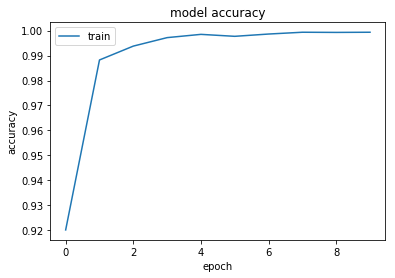

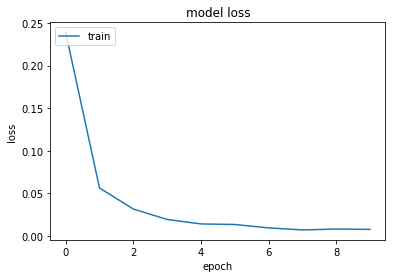

In [21]:
# summarize history for accuracy
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# # summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
import os

modelRootDir = "{}/models".format(rootDir)
fullModelPath = "{}/{}.h5".format(modelRootDir, modelName)

if not os.path.exists(modelRootDir):
    print("create modle directory:{}".format(modelRootDir))
    os.makedirs(modelRootDir)

if not os.path.isfile(fullModelPath):
    logisticRegressionModel.save(fullModelPath)
    print("Saved {} to disk".format(fullModelPath))
else:
    print("ERROR: model was not save. files already exist {}".format(
        fullModelPath))

ERROR: model was not save. files already exist /bme-230a-ebs/models/logisticRegressionTumorNormal.h5


In [23]:
!pwd
!ls -l $fullModelPath

/home/ubuntu/BME-230a
-rw-rw-r-- 1 ubuntu ubuntu 2603772 Mar 16 18:50 /bme-230a-ebs/models/logisticRegressionTumorNormal.h5
